## Implementation of clustering algorithms on 1500 repos with Reviews(Pull Request) metric

### Implemented Three Different clustering algorithms : DBSCAN , KMeans , AgglomerativeClustering

#### 1.Plotted Dendogram on normal and standarized data to find the optimal number of clusters
#### 2.Plotted Dendogram with euclidean and pearson correlation distance metric
#### 3.Analysis of different number of clusters with different distance metric
#### 4.Implemented Three different clustering algorithms with different parameters to find the optimal number of clusters
#### 5.Finding of optimal number of cluster using Elbow method
#### 6.Distribution of repos over different type of clusters

In [1]:
import pandas as pd
import requests
import datetime
import json
import numpy as np
import seaborn as sns
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import math
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [6]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

In [7]:
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')

time_series = ['reviews']#'code-changes-lines','issues-active','issues-closed',
              #'contributors-new','reviews','issues-new',
              #'open-issues-count','reviews-accepted','reviews-declined']
              
def time_series_metrics(repo_id):
    training_days = 365
    
    base_url = 'http://{}:{}/api/unstable/repo-groups/20/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)
    begin_date = datetime.datetime(2019, 4, 1, 0, 0)#datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
    index = pd.date_range(begin_date, periods=training_days, freq='D')
    df = pd.DataFrame(index)
    df.columns = ['date']
    df['date'] = df['date'].astype(str)

    for endpoint in time_series:
        #print(endpoint)
        
        url = base_url + endpoint
        #print("Hitting endpoint: " + url + "\n")
        try:
            data = requests.get(url=url).json()
            #print(data)
        except:
            data = json.loads(json.dumps(requests.get(url=url).text))

        if len(data) == 0:
            print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
            continue
                    
        if 'date' not in data[0]:
            print("Endpoint {} is not a timeseries, moving to next endpoint.\n".format(endpoint))
            continue
                
        metric_df = pd.DataFrame.from_records(data)
        metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
        metric_df['date'] = metric_df['date'].astype(str)
        extra=['repo','rg','week','year']
        for column in metric_df.columns:
            if any(x in column for x in extra):
                metric_df.drop(column,axis=1,inplace=True)
                
        df = pd.DataFrame(pd.merge(df,metric_df.loc[:,metric_df.columns],how = 'left',on = 'date'))
        metric_df.drop('date',axis=1,inplace=True)
        df.rename(columns={i :"{} _ {}".format(endpoint, i) for i in metric_df.columns }, inplace=True)
    return df

### Analysis of 1500+ repos with data over last 365 days


In [8]:
data = pd.read_csv("repo_reviews_all.csv")

In [9]:
data.head()

,repo_id,0,1,2,3,4,5,6,7,8,...,355,356,357,358,359,360,361,362,363,364
0,25738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30125,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0
3,26088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data.index = data.iloc[:,0]
data.drop(['repo_id'],axis=1,inplace=True)

In [11]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
repo_id,,,,,,,,,,,,,,,,,,,,,
25738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30125,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0
26088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
data.shape

(1510, 365)

In [13]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(data))
df.index = data.index

In [14]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
repo_id,,,,,,,,,,,,,,,,,,,,,
25738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000,0.00,0.0,0.000000
25779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000,0.00,0.0,0.000000
30125,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.142857,0.333333,0.0,0.0,0.25,0.0,0.125,0.25,0.0,0.083333
26088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000,0.00,0.0,0.000000
26659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000,0.00,0.0,0.000000


In [15]:
def plot_timeSeries(timeSeries):
         
    fig = plt.figure(figsize=(20,8)) 
    ax = fig.add_subplot(111)
    plt.title('Time_series data of reviews over a year',fontsize=25, fontweight='bold')
    plt.xlabel('Days', fontsize=15, fontweight='bold')
    plt.ylabel('Reviews value', fontsize=15, fontweight='bold')
    major_ticks = np.arange(0, 365, 14)
    ax.set_xticks(major_ticks)
    plt.plot(timeSeries.T)
         

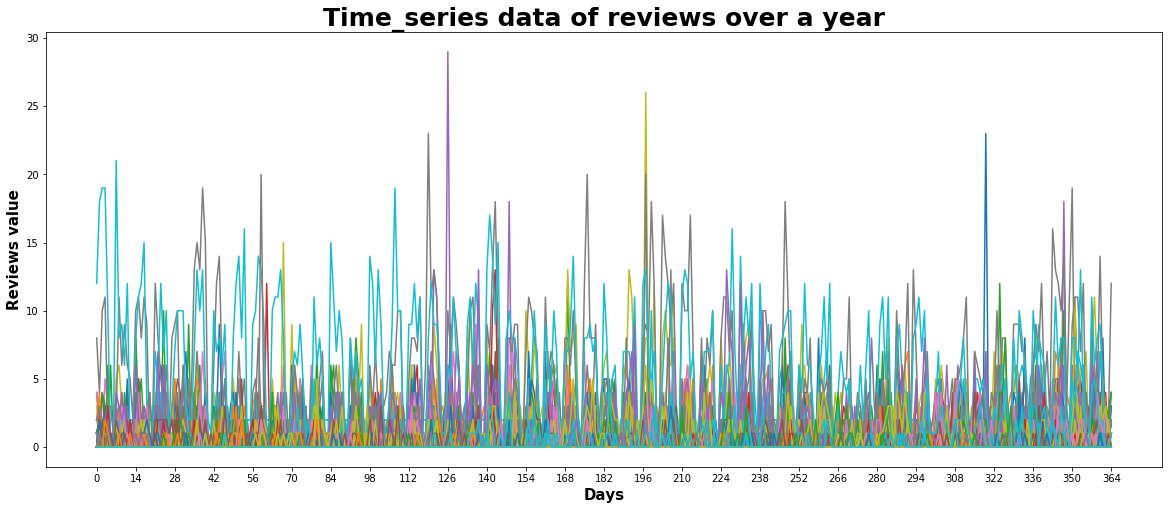

In [16]:
plot_timeSeries(data)

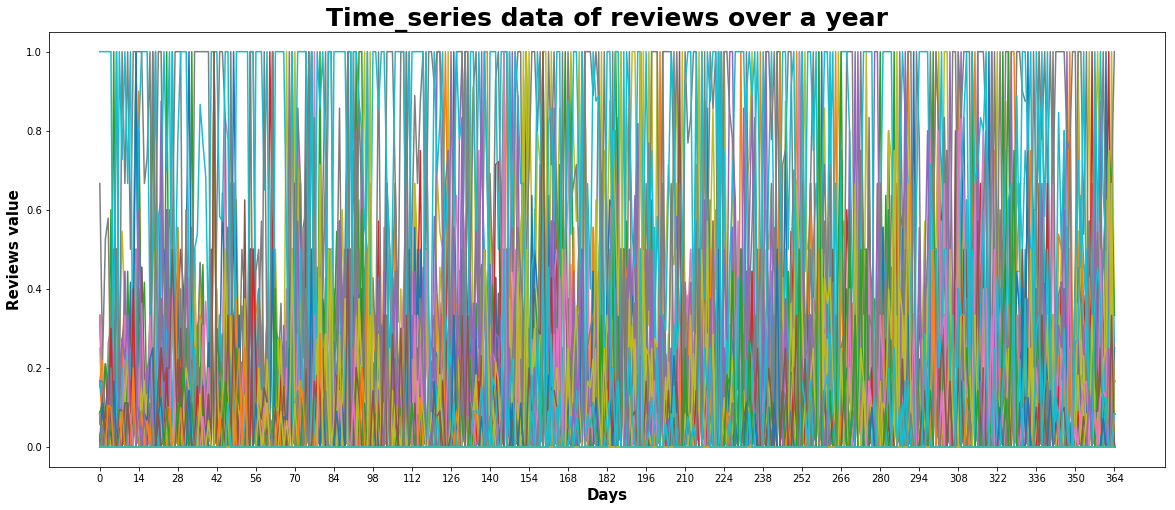

In [17]:
plot_timeSeries(df)

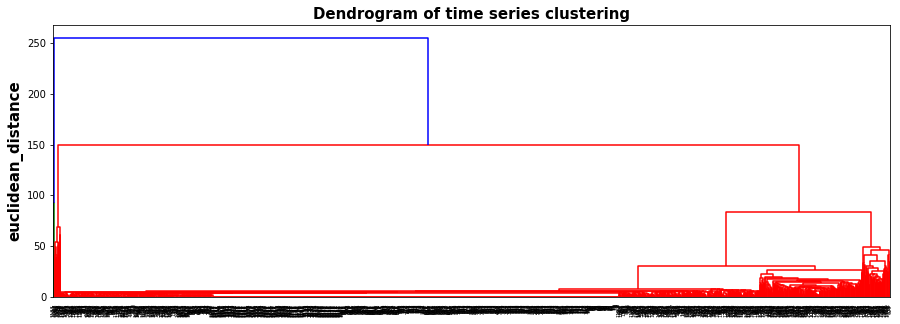

In [18]:
D = hac.linkage(data, method='ward', metric='euclidean')

plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=15, fontweight='bold')
plt.ylabel('euclidean_distance', fontsize=15, fontweight='bold')
hac.dendrogram( D, leaf_rotation=90.,    
                leaf_font_size=5., ) 
plt.show()


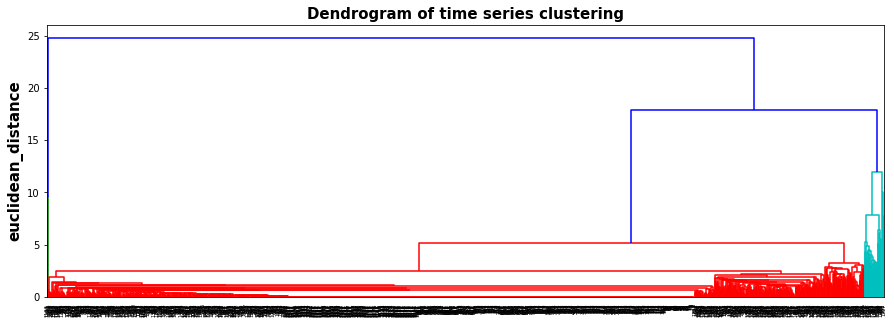

In [19]:
D = hac.linkage(df, method='ward', metric='euclidean')

plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=15, fontweight='bold')
plt.ylabel('euclidean_distance', fontsize=15, fontweight='bold')
hac.dendrogram( D, leaf_rotation=90.,    
                leaf_font_size=5., ) 
plt.show()



In [20]:
def pearson_metric(x,y):
    r = stats.pearsonr(x, y)[0]
    if(np.isnan(r)):
        r=1
    return 1-r

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


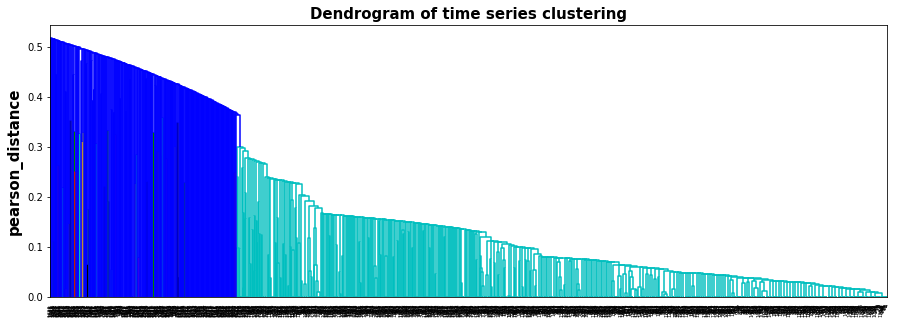

In [21]:
D = hac.linkage(df, method='average', metric=pearson_metric)
#plot_dendogram(D)
plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=15, fontweight='bold')
plt.ylabel('pearson_distance', fontsize=15, fontweight='bold')
hac.dendrogram( D, leaf_rotation=90.,    
                leaf_font_size=5., ) 
plt.show()

In [22]:
def plot_results(timeSeries, D, cut_off_level):
    result = pd.Series(hac.fcluster(D, cut_off_level, criterion='maxclust'))
    clusters = result.unique()       
    figX = 20; figY = 15
    fig = plt.subplots(figsize=(figX, figY))   
    mimg = math.ceil(cut_off_level/2.0)
    gs = gridspec.GridSpec(mimg,2, width_ratios=[1,1])   
    for ipic, c in enumerate(clusters):
        cluster_index = result[result==c].index
        print(ipic, "Cluster number %d has %d elements" % (c, len(cluster_index)))
        ax1 = plt.subplot(gs[ipic])
        ax1.plot(timeSeries.T.iloc[:,cluster_index])
        #print(timeSeries.T.iloc[:,cluster_index])
        ax1.set_title(('Cluster number '+str(c)), fontsize=15, fontweight='bold')      
    plt.show()

0 Cluster number 3 has 1497 elements
1 Cluster number 2 has 11 elements
2 Cluster number 1 has 2 elements


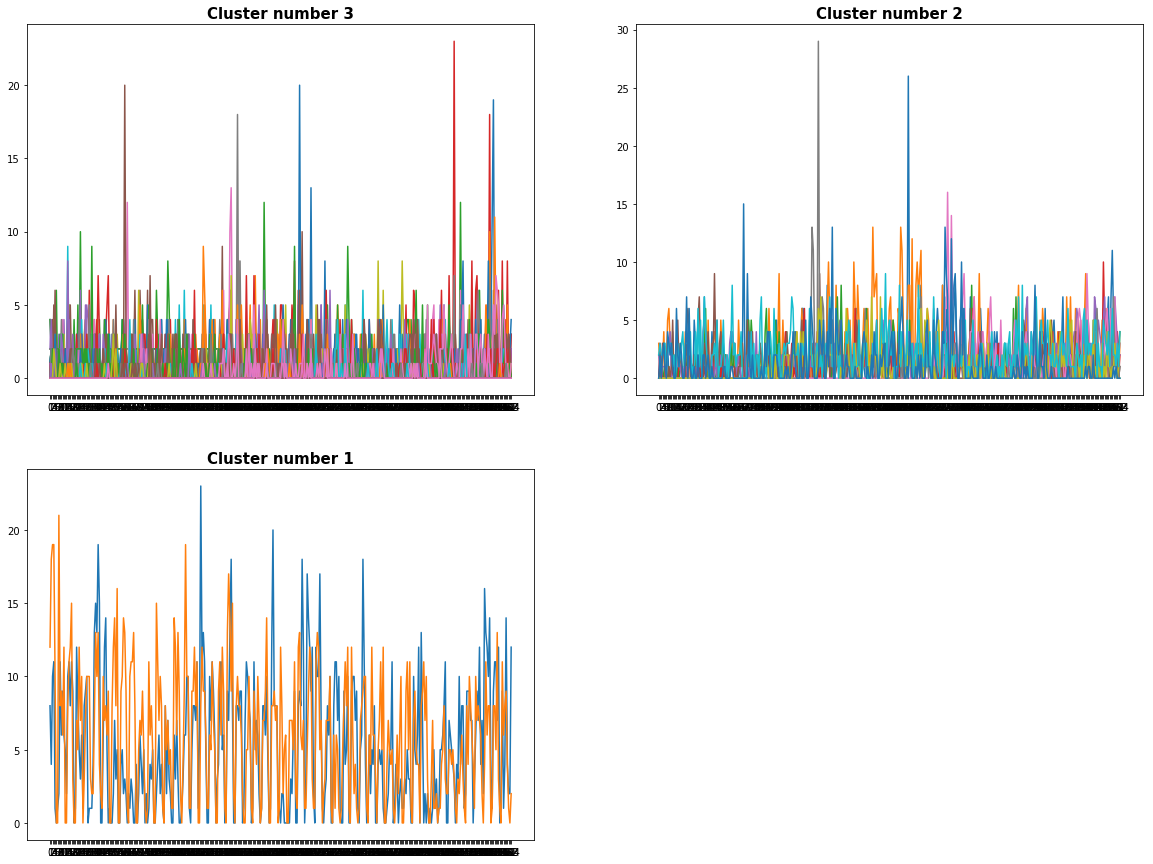

In [23]:
D = hac.linkage(data, method='ward', metric='euclidean')
cut_off_level = 3   # level where to cut off the dendogram
plot_results(data, D, cut_off_level)

0 Cluster number 2 has 1473 elements
1 Cluster number 3 has 35 elements
2 Cluster number 1 has 2 elements


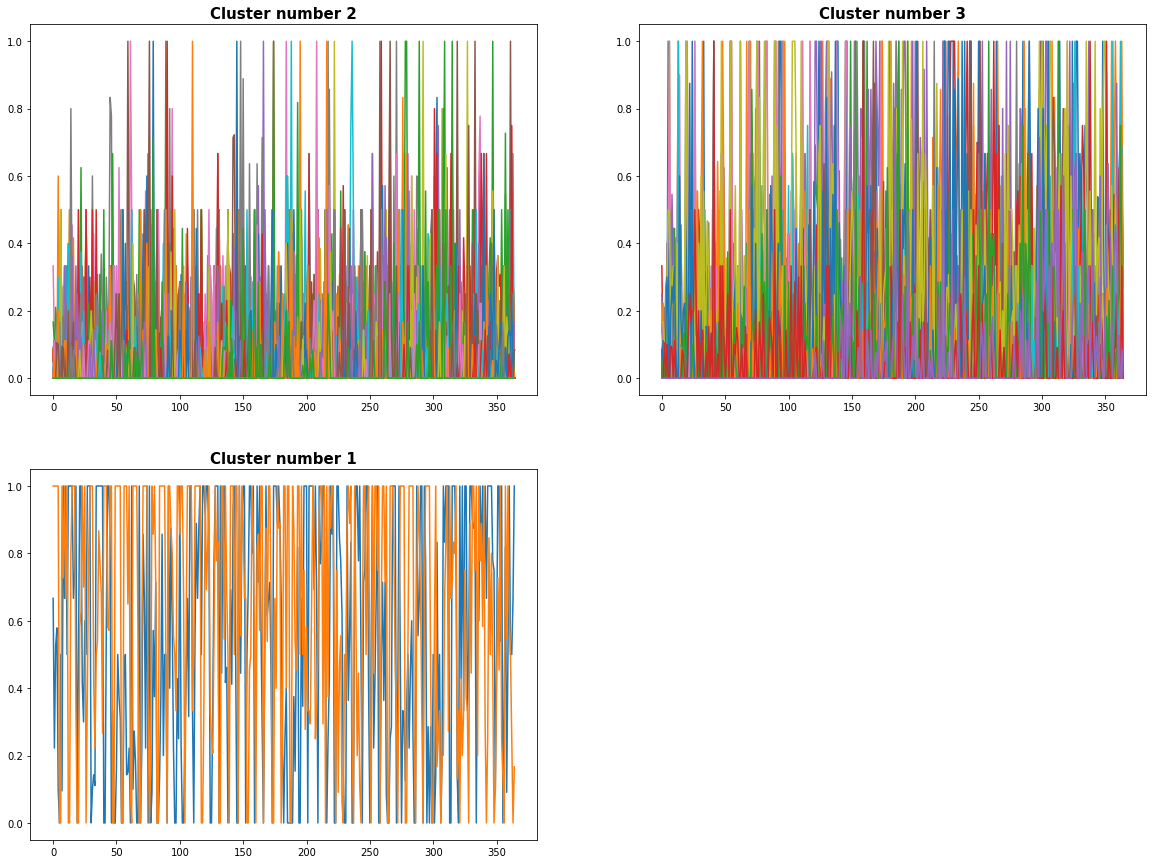

In [24]:
D = hac.linkage(df, method='ward', metric='euclidean')
cut_off_level = 3   # level where to cut off the dendogram
plot_results(df, D, cut_off_level)

0 Cluster number 2 has 1473 elements
1 Cluster number 3 has 30 elements
2 Cluster number 5 has 3 elements
3 Cluster number 4 has 2 elements
4 Cluster number 1 has 2 elements


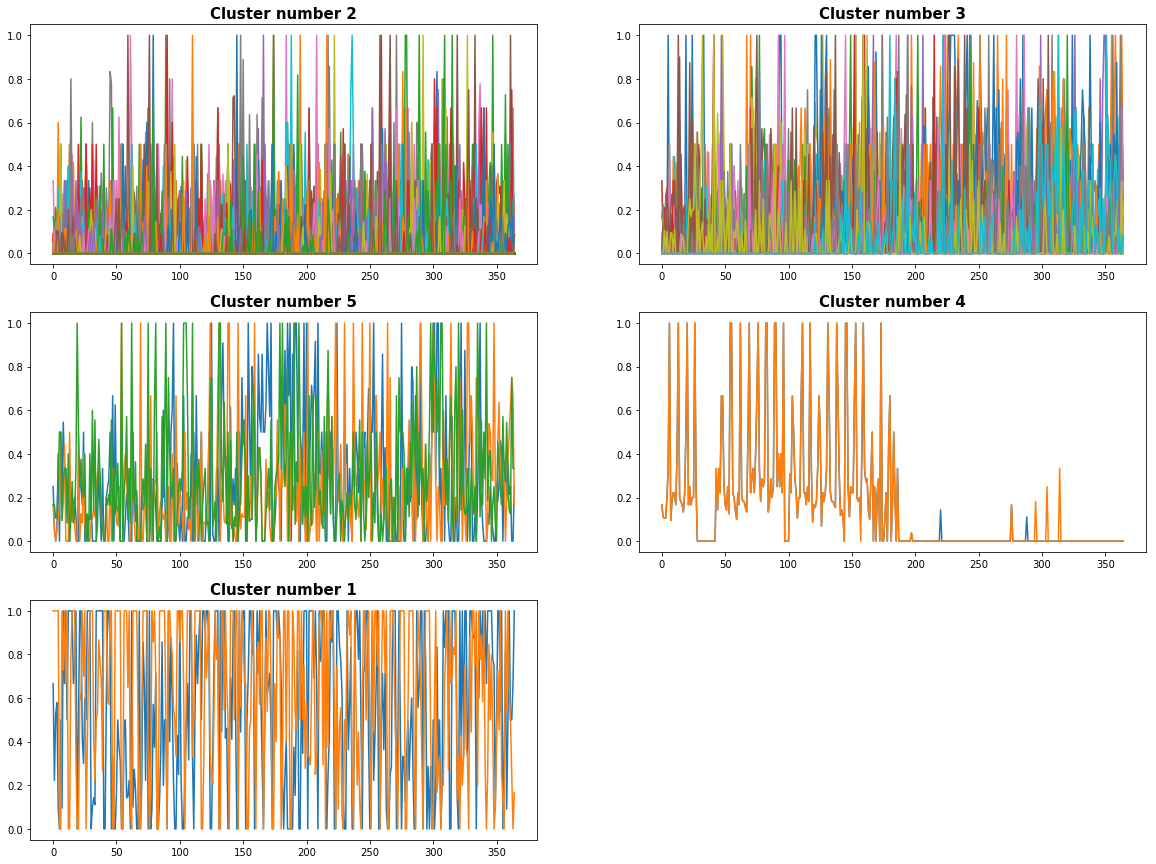

In [25]:
D = hac.linkage(df, method='ward', metric='euclidean')
cut_off_level = 5   # level where to cut off the dendogram
plot_results(df, D, cut_off_level)

## DBSCAN

In [26]:
from sklearn.cluster import DBSCAN

points_count = []
eps_dist = [2,5,7]
min_sam = [1,2,5]
for i in eps_dist:
    
    for j in min_sam:
        
        clustering = DBSCAN(eps=i, min_samples=j,metric='euclidean').fit(df)
        x = clustering.labels_
        unique, counts = np.unique(x, return_counts=True)
        clusters_dbscan={}
        for k in range(unique.shape[0]):
            
            clusters_dbscan[unique[k]] = counts[k]
        #cluster_id.append(unique)
        points_count.append(clusters_dbscan)
        
        

In [27]:
clusters_dbscan

{-1: 2, 0: 1508}

In [28]:
points_count

[{0: 1470,
  1: 1,
  2: 1,
  3: 1,
  4: 1,
  5: 1,
  6: 1,
  7: 1,
  8: 1,
  9: 1,
  10: 2,
  11: 1,
  12: 1,
  13: 1,
  14: 1,
  15: 1,
  16: 1,
  17: 1,
  18: 1,
  19: 1,
  20: 1,
  21: 1,
  22: 1,
  23: 1,
  24: 1,
  25: 1,
  26: 1,
  27: 1,
  28: 1,
  29: 1,
  30: 1,
  31: 1,
  32: 1,
  33: 1,
  34: 1,
  35: 1,
  36: 1,
  37: 1,
  38: 1,
  39: 1},
 {-1: 38, 0: 1470, 1: 2},
 {-1: 40, 0: 1470},
 {0: 1502, 1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1},
 {-1: 6, 0: 1502, 1: 2},
 {-1: 8, 0: 1502},
 {0: 1508, 1: 1, 2: 1},
 {-1: 2, 0: 1508},
 {-1: 2, 0: 1508}]

## KMeans

In [29]:
from sklearn.cluster import KMeans
num_clus = [2,3,4,5,6]
cluster_dist = []
for i in num_clus:
    
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df)
    x = kmeans.labels_
    unique, counts = np.unique(x, return_counts=True)
    clusters_kmeans={}
    for k in range(unique.shape[0]):

        clusters_kmeans[unique[k]] = counts[k]
    #cluster_id.append(unique)
    cluster_dist.append(clusters_kmeans)
    


In [30]:
cluster_dist

[{0: 1504, 1: 6},
 {0: 1495, 1: 13, 2: 2},
 {0: 1483, 1: 5, 2: 2, 3: 20},
 {0: 24, 1: 1481, 2: 1, 3: 3, 4: 1},
 {0: 25, 1: 1478, 2: 1, 3: 3, 4: 1, 5: 2}]

## AgglomerativeClustering

In [31]:
from sklearn.cluster import AgglomerativeClustering

num_clus = [2,3,4,5,6]
cluster_dist = []

for i in num_clus:
    
    cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward').fit(df)
    x = cluster.labels_
    unique, counts = np.unique(x, return_counts=True)
    clusters_kmeans={}
    for k in range(unique.shape[0]):

        clusters_kmeans[unique[k]] = counts[k]
    #cluster_id.append(unique)
    cluster_dist.append(clusters_kmeans)
    



In [35]:
cluster_dist

[{0: 1508, 1: 2},
 {0: 35, 1: 2, 2: 1473},
 {0: 5, 1: 2, 2: 1473, 3: 30},
 {0: 2, 1: 30, 2: 1473, 3: 3, 4: 2},
 {0: 30, 1: 3, 2: 1473, 3: 1, 4: 2, 5: 1}]

In [38]:
X = []
Y = []

for i in range(1,31):
    
    kmeans = KMeans(n_clusters =i)
    
    kmeans.fit(df)
    
    X.append(i)
    
    avg_cluspoint = kmeans.inertia_ / data.shape[0]
    
    Y.append(avg_cluspoint)

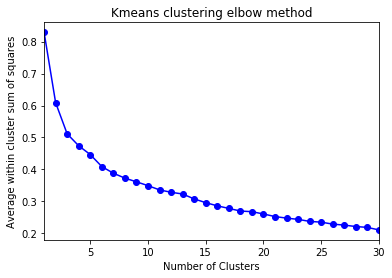

In [39]:
plt.plot(X,Y,'-bo')
plt.xlim(1,30)

plt.xlabel("Number of Clusters")
plt.ylabel("Average within cluster sum of squares")
plt.title("Kmeans clustering elbow method")
plt.show()

## Now we will analyse how effectively this algorithm worked

In [42]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit(df)
x = cluster.labels_

In [43]:
x

array([2, 2, 0, ..., 2, 2, 2])

In [44]:
df_frame = pd.DataFrame(data.sum(axis=1))

In [45]:
df_frame['cluster'] = x

In [47]:
df_frame.columns = ['reviews','cluster']
df_frame.head()

,reviews,cluster
repo_id,,
25738,2.0,2
25779,0.0,2
30125,254.0,0
26088,0.0,2
26659,0.0,2


In [52]:
df_frame['cluster'] == 2
cluster_range = {}
for i in range(3):
    filt = df_frame['cluster'] == i
    cluster_range['cluster_{}_min'.format(i)] = df_frame[filt]['reviews'].min()
    cluster_range['cluster_{}_max'.format(i)] = df_frame[filt]['reviews'].max()
    

In [53]:
cluster_range

{'cluster_0_min': 100.0,
 'cluster_0_max': 859.0,
 'cluster_1_min': 1877.0,
 'cluster_1_max': 2129.0,
 'cluster_2_min': 0.0,
 'cluster_2_max': 147.0}

In [54]:
df_frame['repo_id'] = df_frame.index
df_frame.head()

,reviews,cluster,repo_id
repo_id,,,
25738,2.0,2,25738
25779,0.0,2,25779
30125,254.0,0,30125
26088,0.0,2,26088
26659,0.0,2,26659


In [56]:
df_frame.reset_index(inplace=True,drop=True)

In [57]:
df_frame.head()

,reviews,cluster,repo_id
0,2.0,2,25738
1,0.0,2,25779
2,254.0,0,30125
3,0.0,2,26088
4,0.0,2,26659


### Cluster_range_distribution

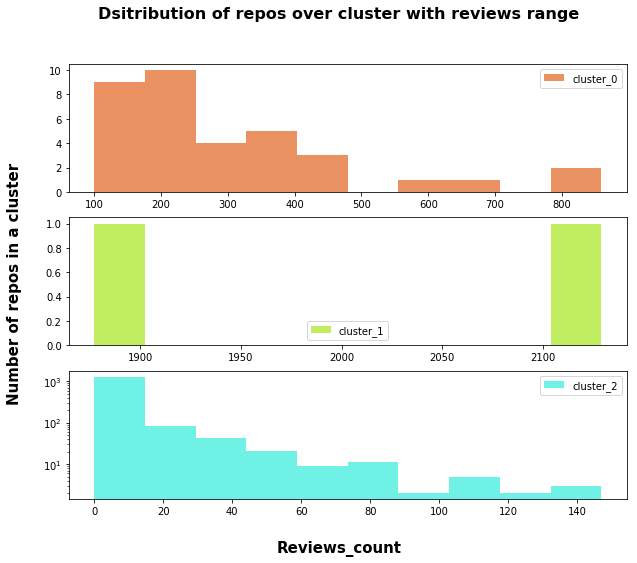

In [97]:
#eb9263','#c1ed61','#6ff2e5
fig,ax = plt.subplots(3,1,figsize=(10,8))

filt_2 = df_frame['cluster'] == 2
filt_1 = df_frame['cluster'] == 1
filt_0 = df_frame['cluster'] == 0

ax[0].hist(df_frame[filt_0]['reviews'],color='#eb9263',label='cluster_0')
ax[1].hist(df_frame[filt_1]['reviews'],color='#c1ed61',label='cluster_1')
ax[2].hist(df_frame[filt_2]['reviews'],color='#6ff2e5',label='cluster_2',log=True)

#plt.xlabel('Reviews_count',fontsize=15, fontweight='bold')
#fig.supylabel('Number of repos in a cluster',fontsize=15, fontweight='bold')
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5,0.04, "Reviews_count", ha="center", va="center",fontsize=15, fontweight='bold')
fig.text(0.05,0.5, "Number of repos in a cluster", ha="center", va="center", rotation=90,fontsize=15, fontweight='bold')
fig.suptitle('Dsitribution of repos over cluster with reviews range',fontweight='bold', fontsize=16)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

In [98]:
df_frame.head()

,reviews,cluster,repo_id
0,2.0,2,25738
1,0.0,2,25779
2,254.0,0,30125
3,0.0,2,26088
4,0.0,2,26659


In [103]:
df_frame.to_csv("repo_reviews_cluster.csv",index=False)